In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json, sys

from azure.ai.ml import command
from azure.ai.ml.entities import Data
from azure.ai.ml.entities import AzureBlobDatastore
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes, InputOutputModes

In [2]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

In [3]:
with open("./config.json") as f:
    config = json.load(f)
print(config)

{'subscription_id': '46668180-b0ad-4a49-bed9-88f16f315dce', 'resource_group': 'MLGroup', 'workspace_name': 'ShivaMLservice', 'location': 'westus2'}


In [4]:
workspace_name = config["workspace_name"]
resource_group = config["resource_group"]
subscription_id = config["subscription_id"]
location = config["location"]


In [5]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace_name,
)
ml_client

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x7ff5b0de5ea0>,
         subscription_id=46668180-b0ad-4a49-bed9-88f16f315dce,
         resource_group_name=MLGroup,
         workspace_name=ShivaMLservice)

In [6]:
import os

dependencies_dir = "./environment_setup"
os.makedirs(dependencies_dir, exist_ok=True)

In [7]:
%%writefile {dependencies_dir}/conda.yml
name: spam-mlops-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pip:  
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0
    - numpy
    - pandas
    - matplotlib
   

Overwriting ./environment_setup/conda.yml


In [9]:
"""Load labeled spam dataset."""

# Path where csv files are located
base_path = "./data/csv_data"

# List of csv files with full path
csv_files = [os.path.join(base_path, csv) for csv in os.listdir(base_path)]

dfs = []
# List of dataframes for each file
for filename in csv_files:
    if filename.endswith('.csv'):
        dfs.append(pd.read_csv(filename))
        
# Concatenate all data into one DataFrame
df = pd.concat(dfs)

# Rename columns
df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

# Set a seed for the order of rows
df = df.sample(frac=1, random_state=824)

df = df.reset_index()

df.tail()


,index,COMMENT_ID,AUTHOR,DATE,text,label
1133,69,z12qvnw51y31ulrx304cjbkq1yzqzdkiytg0k,jessica durham,2014-09-09T06:10:07,Please help me give my son a grave. http://ww...,1
1134,206,z13wt1vrismyzpiij04cj5vz4nzlyj4yfzo0k,Alexander Mcdonald,2014-10-13T09:19:13,"Anyone Who LOVEs music , please go check out m...",1
1135,127,z13rfjuxmtm3vd2eb23qi1brgq3ic5nxv04,Marshmallow Kingdom,2015-05-20T12:40:57.549000,THUMBS UP FOR ROBO GUY BABY﻿,0
1136,237,z13iwppp5kf4gnyxn04cjns5kzn4xd0qdwk0k,juanmanuel cespedes,2014-11-07T22:59:13,i hate this music. fucking singer and every ko...,0
1137,133,z12de5li5lzwcbblp23gc11zmli4t5r10,Dicky Tricahyadi,2015-05-20T05:49:45.161000,LMFAO IS THE BEST﻿,0


Value counts for each class:

1    586
0    552
Name: label, dtype: int64



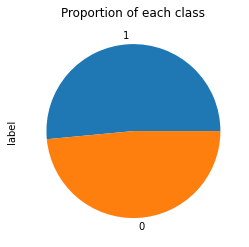

In [10]:
# Print actual value count
print(f"Value counts for each class:\n\n{df.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

In [11]:
# Drop unused columns
df = df.drop(['index', 'COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)
df.shape

(1138, 2)

In [12]:
try:
    os.makedirs('./data/training_data', exist_ok=True)
    df.to_csv('./data/training_data/spam.csv', index=False, header=True)
    print('spam.csv training data created')
except:
    print("directory already exists")


spam.csv training data created


In [14]:
from azure.ai.ml.entities import Data

my_path = './data/training_data/spam.csv'

my_data = Data(
    path=my_path,
    type=AssetTypes.URI_FILE,
    description="youtube data for spam classification mlops example",
    name="spam_class"
)

ml_client.data.create_or_update(my_data)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'spam_class', 'description': 'youtube data for spam classification mlops example', 'tags': {}, 'properties': {}, 'id': '/subscriptions/46668180-b0ad-4a49-bed9-88f16f315dce/resourceGroups/MLGroup/providers/Microsoft.MachineLearningServices/workspaces/ShivaMLservice/data/spam_class/versions/3', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-instance/code/Users/shchitt/SpamClassification', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7ff56d32e5f0>, 'serialize': <msrest.serialization.Serializer object at 0x7ff56d32f970>, 'version': '3', 'latest_version': None, 'path': 'azureml://subscriptions/46668180-b0ad-4a49-bed9-88f16f315dce/resourcegroups/MLGroup/workspaces/ShivaMLservice/datastores/workspaceblobstore/paths/LocalUpload/43016c59cd727

In [41]:
spam_dataset = ml_client.data.get(name="spam_class", version="3")
spam_dataset.dump

<bound method Asset.dump of Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'spam_class', 'description': 'youtube data for spam classification mlops example', 'tags': {}, 'properties': {}, 'id': '/subscriptions/46668180-b0ad-4a49-bed9-88f16f315dce/resourceGroups/MLGroup/providers/Microsoft.MachineLearningServices/workspaces/ShivaMLservice/data/spam_class/versions/3', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standard-instance/code/Users/shchitt/SpamClassification', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7ff566267dc0>, 'serialize': <msrest.serialization.Serializer object at 0x7ff5661d7c40>, 'version': '3', 'latest_version': None, 'path': 'azureml://subscriptions/46668180-b0ad-4a49-bed9-88f16f315dce/resourcegroups/MLGroup/workspaces/ShivaMLservice/datastores/workspaceblobstore/pat

In [44]:
spam=Input(type="uri_file", path=spam_dataset.id)
spam

{'type': 'uri_file', 'path': '/subscriptions/46668180-b0ad-4a49-bed9-88f16f315dce/resourceGroups/MLGroup/providers/Microsoft.MachineLearningServices/workspaces/ShivaMLservice/data/spam_class/versions/3'}

In [31]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_DS3_V2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

    print(f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}")

You already have a cluster named cpu-cluster, we'll reuse it as is.


In [32]:
import os

dependencies_dir = "./environment_setup"
os.makedirs(dependencies_dir, exist_ok=True)

In [33]:
%%writefile {dependencies_dir}/conda.yml
name: spam-mlops-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pip:  
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0
    - numpy
    - pandas
    - matplotlib

Overwriting ./environment_setup/conda.yml


In [8]:
from azure.ai.ml.entities import Environment

custom_env_name = "spam-mlops-env"

job_env = Environment(
    name=custom_env_name,
    description="Custom environment for sklearn image classification",
    conda_file=os.path.join(dependencies_dir, "conda.yml"),
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
)
job_env = ml_client.environments.create_or_update(job_env)

print(
    f"Environment with name {job_env.name} is registered to workspace, the environment version is {job_env.version}"
)

Environment with name spam-mlops-env is registered to workspace, the environment version is 6


In [34]:
import os

train_src_dir = "./scripts/training"
os.makedirs(train_src_dir, exist_ok=True)

In [56]:
%%writefile {train_src_dir}/main.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json, sys
import joblib
import mlflow
import argparse

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# define functions
def main(args):
    
    # Start Logging
    mlflow.start_run()
    
    # enable auto logging
    #mlflow.autolog()

    # read in data
    df = pd.read_csv(args.spam_csv)
    
    # Save the text into the X variable
    X = df.drop("label", axis=1)

    # Save the true labels into the y variable
    y = df["label"]

    # Use 1/5 of the data for testing later
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=args.test_size, random_state=args.random_state, stratify=y)

    # Print number of comments for each set
    print(f"There are {X_train.shape[0]} comments for training.")
    print(f"There are {X_test.shape[0]} comments for testing")

    # Allow unigrams and bigrams
    vectorizer = CountVectorizer(ngram_range=(1, 5))

    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_train.text.tolist())

    # Fit model
    clf=MultinomialNB()
    clf.fit(X=X_train_vect, y=y_train)

    # Vectorize test text
    X_test_vect = vectorizer.transform(X_test.text.tolist())

    # Make predictions for the test set
    preds = clf.predict(X_test_vect)

    # Return accuracy score
    true_acc = accuracy_score(preds, y_test)
    true_acc

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds)

    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

    precision = precision_score(y_test, preds)
    print('Precision: %.3f' % precision)

    recall = recall_score(y_test, preds)
    print('Recall: %.3f' % recall)

    f1 = f1_score(y_test, preds)
    print('f1: %.3f' % f1)
    
    
    mlflow.log_metric("Accuracy", true_acc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1", f1)
    


    
    #### MODEL
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=clf,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )
    
    # Saving the model to a file
    print("Saving the model via MLFlow")
    mlflow.sklearn.save_model(
        sk_model=clf,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )


    
       
    os.makedirs('./outputs', exist_ok=True)
    with open(args.registered_model_name, 'wb') as file:
        joblib.dump(value=clf, filename='outputs/' + args.registered_model_name)    

    with open(args.registered_vec_name, 'wb') as file:
        joblib.dump(value=vectorizer, filename='outputs/' + args.registered_vec_name)
        
    # Stop Logging
    mlflow.end_run()


# run script
if __name__ == "__main__":
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--spam-csv", type=str)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    parser.add_argument("--registered_vec_name", type=str, help="vectorizer name")
    parser.add_argument("--random_state", type=int, default=42)
    parser.add_argument("--test_size", type=float, required=False, default=0.20)

    # parse args
    args = parser.parse_args()
    
    # run main function
    main(args)

Overwriting ./scripts/training/main.py


In [57]:
model_name = "spam-classifier"
vec_name = "count-vec"

# create the command
job = command(
    code="./scripts/training",  # local path where the code is stored
    command="python main.py --spam-csv ${{inputs.spam}} --registered_model_name ${{inputs.registered_model_name}} --registered_vec_name ${{inputs.registered_vec_name}}",
    inputs=dict(
        spam=Input(type="uri_file", path=spam_dataset.id),
        registered_model_name=model_name,
        registered_vec_name=vec_name,
    ),
    environment=job_env,
    compute="cpu-cluster",
    display_name="spam-class-mlops-v2",
    experiment_name="exp-spam-class-mlops-v2",
    #description=""
)

In [58]:
# submit the command
returned_job = ml_client.create_or_update(job)
returned_job

Uploading training (0.01 MBs): 100%|██████████| 10758/10758 [00:00<00:00, 248197.59it/s]




Experiment,Name,Type,Status,Details Page
exp-spam-class-mlops-v2,affable_honey_hjpf1r287w,command,Starting,Link to Azure Machine Learning studio


In [59]:
run_id = {}
run_id["run_id"] = returned_job.name
run_id["experiment_name"] = returned_job.experiment_name
with open("./configuration/run_id.json", "w") as outfile:
    json.dump(run_id, outfile)

In [18]:
# Raise exception if run fails
if run.get_status() == "Failed":
    raise Exception(
        "Training on local failed with following run status: {} and logs: \n {}".format(
            run.get_status(), run.get_details_with_logs()
        )
    )

# Writing the run id to /aml_config/run_id.json

run_id = {}
run_id["run_id"] = run.id
run_id["experiment_name"] = run.experiment.name
with open("./configuration/run_id.json", "w") as outfile:
    json.dump(run_id, outfile)

In [19]:
# Get all metris logged in the run
run.get_metrics()
metrics = run.get_metrics()
print(metrics)

{'Accuracy': 0.9166666666666666, 'Precision': 0.8769230769230769, 'Recall': 0.9743589743589743, 'F1_Score': 0.923076923076923}


In [20]:
run.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/70_driver_log.txt',
 'logs/azureml/31319_azureml.log',
 'outputs/count_vec.pkl',
 'outputs/spam_classifier.pkl']

In [21]:
# Get the latest run_id
with open("./configuration/run_id.json") as f:
    config = json.load(f)

new_model_run_id = config["run_id"]
experiment_name = config["experiment_name"]
exp = Experiment(workspace=ws, name=experiment_name)

In [22]:

run_id = {}
try:
    # Get most recently registered model, we assume that is the model in production. Download this model and compare it with the recently trained model by running test with same data set.
    model_list = Model.list(ws)
    production_model = next(
        filter(
            lambda x: x.created_time == max(model.created_time for model in model_list),
            model_list,
        )
    )
    production_model_run_id = production_model.tags.get("run_id")
    run_list = exp.get_runs()
    # production_model_run = next(filter(lambda x: x.id == production_model_run_id, run_list))

    # Get the run history for both production model and newly trained model and compare R2
    production_model_run = Run(exp, run_id=production_model_run_id)
    new_model_run = Run(exp, run_id=new_model_run_id)

    production_model_acc = production_model_run.get_metrics().get("Accuracy")
    new_model_acc = new_model_run.get_metrics().get("Accuracy")
    print(
        "Current Production model accuracy: {}, New trained model accuracy: {}".format(
            production_model_acc, new_model_acc
        )
    )

    promote_new_model = False
    run_id["run_id"] = production_model_run_id
    
    
    if new_model_acc >= production_model_acc:
        promote_new_model = True
        run_id["run_id"] = new_model_run_id
        print("New trained model performs equal or better, thus it will be registered")
except:
    promote_new_model = True
    print("This is the first model to be trained, thus nothing to evaluate for now")
    run_id["run_id"] = new_model_run_id

This is the first model to be trained, thus nothing to evaluate for now


In [23]:
print(production_model_run_id)

None


In [24]:
run_id["experiment_name"] = experiment_name

with open("./configuration/run_id.json", "w") as outfile:
    json.dump(run_id, outfile)
    
print(run_id)

{'run_id': 'spam-mlops-localrun_1655809391_33e4d418', 'experiment_name': 'spam-mlops-localrun'}


In [25]:
# Get the latest evaluation result
try:
    with open("./configuration/run_id.json") as f:
        config = json.load(f)
    if not config["run_id"]:
        raise Exception("No new model to register as production model perform better")
except:
    print("No new model to register as production model perform better")
    # raise Exception('No new model to register as production model perform better')
    sys.exit(0)

In [26]:
run_id = config["run_id"]
experiment_name = config["experiment_name"]
exp = Experiment(workspace=ws, name=experiment_name)

run = Run(experiment=exp, run_id=run_id)
names = run.get_file_names
print("Experiment run files:", names())
print("Run ID for last run: {}".format(run_id))

Experiment run files: ['azureml-logs/60_control_log.txt', 'azureml-logs/70_driver_log.txt', 'logs/azureml/31319_azureml.log', 'outputs/count_vec.pkl', 'outputs/spam_classifier.pkl']
Run ID for last run: spam-mlops-localrun_1655809391_33e4d418


In [27]:
#model_local_dir = "model"
#os.makedirs(model_local_dir, exist_ok=True)

# Download Model to Project root directory
model_name = "spam_classifier.pkl"
cv_name = "count_vec.pkl"

run.download_file(
    name="./outputs/" + model_name, output_file_path="./model/" + model_name
)
run.download_file(
    name="./outputs/" + cv_name, output_file_path="./model/" + cv_name
)
print("Downloaded model {} to model directory".format(model_name))
print("Downloaded Vectorizer {} to model directory".format(cv_name))



Downloaded model spam_classifier.pkl to model directory
Downloaded Vectorizer count_vec.pkl to model directory


In [28]:
model = Model.register(
    model_path='./model/spam_classifier.pkl',  # this points to a local file
    model_name='spam_classifier',  # this is the name the model is registered as
    tags={"area": "spam", "type": "classification", "run_id": run_id},
    description="Spam Classifier model",
    workspace=ws,
)
#os.chdir("..")
print(
    "Model registered: {} \nModel Description: {} \nModel Version: {}".format(
        model.name, model.description, model.version
    )
)

Registering model spam_classifier
Model registered: spam_classifier 
Model Description: Spam Classifier model 
Model Version: 3


In [29]:
# Writing the registered model details to /aml_config/model.json
model_json = {}
model_json["model_name"] = model.name
model_json["model_version"] = model.version
model_json["run_id"] = run_id
with open("./configuration/model.json", "w") as outfile:
    json.dump(model_json, outfile)
    

In [30]:
cv = Model.register(
    model_path="./model/count_vec.pkl",  # this points to a local file
    model_name='count_vec',  # this is the name the model is registered as
    tags={"area": "spam", "type": "vectorizer", "run_id": run_id},
    description="Count Vectorizer for Spam Classifier model",
    workspace=ws,
)
#os.chdir("..")
print(
    "Model registered: {} \nModel Description: {} \nModel Version: {}".format(
        cv.name, cv.description, cv.version
    )
)

Registering model count_vec
Model registered: count_vec 
Model Description: Count Vectorizer for Spam Classifier model 
Model Version: 3


In [31]:
# Writing the registered model details to /aml_config/model.json
cv_json = {}
cv_json["cv_name"] = cv.name
cv_json["cv_version"] = cv.version
cv_json["run_id"] = run_id
with open("./configuration/cv.json", "w") as outfile:
    json.dump(cv_json, outfile)

In [33]:
try:
    with open("./configuration/model.json") as f:
        config = json.load(f)
except:
    print("No new model to register thus no need to create new scoring image")
    # raise Exception('No new model to register as production model perform better')
    sys.exit(0)

In [34]:
model_name = config["model_name"]
model_version = config["model_version"]

model_list = Model.list(workspace=ws)
model, = (m for m in model_list if m.version == model_version and m.name == model_name)
print(
    "Model picked: {} \nModel Description: {} \nModel Version: {}".format(
        model.name, model.description, model.version
    )
)

Model picked: spam_classifier 
Model Description: Spam Classifier model 
Model Version: 3


In [35]:
try:
    with open("./configuration/cv.json") as f:
        cv_config = json.load(f)
except:
    print("No new model to register thus no need to create new scoring image")
    # raise Exception('No new model to register as production model perform better')
    sys.exit(0)

In [36]:
cv_name = cv_config["cv_name"]
cv_version = cv_config["cv_version"]


cv_list = Model.list(workspace=ws)
cv, = (m for m in model_list if m.version == cv_version and m.name == cv_name)
print(
    "Model picked: {} \nModel Description: {} \nModel Version: {}".format(
        cv.name, cv.description, cv.version
    )
)

Model picked: count_vec 
Model Description: Count Vectorizer for Spam Classifier model 
Model Version: 3


In [37]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
import sklearn


environment = Environment('my-sklearn-environment')
environment.python.conda_dependencies = CondaDependencies.create(conda_packages=[
    'pip==20.2.4'],
    pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'pandas',
    'matplotlib',
    'scikit-learn=={}'.format(sklearn.__version__)
])

In [38]:
with open('./scripts/scoring/score.py') as f:
    print(f.read())

import os
import pickle
import joblib
import json
import numpy
from azureml.core.model import Model
#from sklearn.feature_extraction.text import CountVectorizer


def init():
    global model, vectorizer

    # load the model from file into a global object
    model_path = Model.get_model_path(model_name='spam_classifier')
    cv_path = Model.get_model_path(model_name='count_vec')

    print("model_path: ", model_path)
    print("cv_path: ", cv_path)
    
    model = joblib.load(model_path) 
    vectorizer = joblib.load(cv_path)
   


def run(raw_data):
    try:
        data = json.loads(raw_data)["data"]  
        vec_data = vectorizer.transform(data)        
        result=model.predict(vec_data)
        return json.dumps({"result": result.tolist()})
    
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})





In [39]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script='./scripts/scoring/score.py', environment=environment)

In [40]:
from azureml.core.webservice import LocalWebservice

# This is optional, if not provided Docker will choose a random unused port.
deployment_config = LocalWebservice.deploy_configuration(port=6789)

local_service = Model.deploy(ws, "spam-local-test", [model, cv], inference_config, deployment_config, overwrite=True)
local_service.wait_for_deployment()

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry shivamlservice5116782614.azurecr.io
Logging into Docker registry shivamlservice5116782614.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM shivamlservice5116782614.azurecr.io/azureml/azureml_90d3e31019601b5ca0f837fe7d72d710
 ---> 3ffad9ea50ee
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 56000017480b
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjQ2NjY4MTgwLWIwYWQtNGE0OS1iZWQ5LTg4ZjE2ZjMxNWRjZSIsInJlc291cmNlR3JvdXBOYW1lIjoibWxncm91cCIsImFjY291bnROYW1lIjoic2hpdmFtbHNlcnZpY2UiLCJ3b3Jrc3BhY2VJZCI6IjFmMTBmMWVlLWIxNDctNDZiZi04N2NlLWNhMDk2ZWEzMWQ5NyJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 422b71e9990e
 ---> 64f51086f76e
Step 4/5 : RUN mv '/var/azureml-app/tmpwal7ilmo.py' /var/azureml-app/main.py
 ---> Running in faa7b0a4b545
 ---> a8d7caae0c4f
Step 5/

In [41]:
print(local_service.state)
print()
print(local_service.get_logs())

running

2022-06-21T11:05:35,530490611+00:00 - gunicorn/run 
2022-06-21T11:05:35,532324020+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_017b0876b690e4bf560aa2fb28e1e9da/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_017b0876b690e4bf560aa2fb28e1e9da/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_017b0876b690e4bf560aa2fb28e1e9da/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_017b0876b690e4bf560aa2fb28e1e9da/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_017b0876b690e4bf560aa2fb28e1e9da/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
2022-06-21T11:05:35,548559699+00:00 - rsyslog/run 
2022-06-21T11:05:35,552830520+00:00 - iot-server/run 

In [42]:
import pandas as pd

data = pd.read_csv("./data/retraining_data/Youtube05-Shakira.csv")
data = data.rename(columns={"CONTENT": "text", "CLASS": "label"})
data = data.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

data_X = data.drop("label", axis=1)
y = data["label"]

data_X.head()

,text
0,Nice song﻿
1,I love song ﻿
2,I love song ﻿
3,"860,000,000 lets make it first female to reach..."
4,shakira is best for worldcup﻿


In [46]:
input_payload = json.dumps({
    'data': data_X['text'].tolist()
})

json.loads(input_payload)["data"]

['Nice song\ufeff',
 'I love song \ufeff',
 'I love song \ufeff',
 '860,000,000 lets make it first female to reach one billion!! Share it and replay it! \ufeff',
 'shakira is best for worldcup\ufeff',
 'The best world cup song ever!!!!\ufeff',
 'I love\ufeff',
 'SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakira GuruOfMovie\ufeff',
 'Awesome \ufeff',
 'I like shakira..\ufeff',
 'Shakira - Waka Waka <br />LOVE THIS SONG!!!!!!!!!!!!!!!\ufeff',
 'Why so many disliked??????!!!!!!😯\ufeff',
 'I don&#39;t think this song will ever get old \ufeff',
 'Love song\ufeff',
 'wery good\ufeff',
 'Every time I hear this song, I think about Iniesta&#39;s goal against the Netherlands...\ufeff',
 'Whose watching this in 2015. If so hi-5\ufeff',
 'I love this song so much &lt;3<br />Keep em&#39; coming!\ufeff',
 'i love this song thumsb up to you\ufeff',
 'Waka best one\ufeff',
 '5 years later i still love this song\xa0<br />~Axy665\ufeff',
 'Like\ufeff',
 'Check out this playlist on YouTube:\ufeff',
 'Her v

In [62]:
output = local_service.run(input_payload)
result = json.loads(output)['result']
print(result)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [63]:
y.tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,


In [65]:
from sklearn.metrics import classification_report

print(classification_report(y, result))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       196
           1       0.87      0.93      0.90       174

   micro avg       0.90      0.90      0.90       370
   macro avg       0.90      0.90      0.90       370
weighted avg       0.90      0.90      0.90       370



In [70]:
print(sum(y!=result))
print(sum(y==result))
print(len(y))
print( sum(y==result) / len(y))

37
333
370
0.9
